In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font',family='serif',size='16')
fig = plt.figure(1,figsize=(7,5))
#fig = plt.figure(1,figsize=(7, 5)) ## To save figure.

tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.) 

<Figure size 504x360 with 0 Axes>

In [2]:
import copy

# Hartree-Fock for He atom

## $\phi(\boldsymbol{r} ) = \sum_{p=1}^{4}C_p \chi_p(\boldsymbol{r})$
 $\left[
-\frac{1}{2}\nabla^2_1 - \frac{2}{r_1} + \sum_{r,s=1}^{4}C_r C_s\int {\rm{d}}^3 r_2\, \chi_r(\boldsymbol{r}_2)
\chi_s(\boldsymbol{r}_2)\frac{1}{\vert \boldsymbol{r}_1 - \boldsymbol{r}_2 \vert}
\right]\sum_{q=1}^{4}C_q \chi_q (\boldsymbol{r}_1) = E' \sum_{q=1}^{4}C_q \chi_q(\boldsymbol{r}_1)$

$\sum_{p,q} \left(
h_{pq} + \sum_{r,s}C_r C_s Q_{prqs}
\right) C_q = E'\sum_{p,q}S_{pq}C_{q}$

$\begin{aligned}
h_{pq} & = \langle \chi_{p} \vert -\frac{1}{2}\nabla^2 - \frac{2}{r}\vert \chi_q \rangle \\
Q_{prqs} & = \int {\rm{d}}^3r_1\, {\rm{d}}^3r_2\, \chi_p (\boldsymbol{r}_1)\chi_r (\boldsymbol{r}_2) \frac{1}{\vert \boldsymbol{r}_1 - \boldsymbol{r}_2 \vert }\chi_q (\boldsymbol{r}_1)\chi_s (\boldsymbol{r}_2)= [pq\vert rs] \\
S_{pq} & = \langle \chi_p \vert \chi_q \rangle \\
\end{aligned}$

Here, in actural calculations, we use $Q_{pq,rs}\equiv [pr\vert rs]$ (Q[p,q,r,s]) instead of the original $Q_{prqs}$, since the summation operation in our code is to sum over the $2^{\rm{nd}}$ electron first, and then sum over the $1^{\rm{st}}$ electron.

$\chi_p (\boldsymbol{r}) = e^{-\alpha_{p} r^2}$


$\begin{aligned}
\alpha_1 & = 0.298073 \\
\alpha_2 & = 1.242567 \\
\alpha_3 & = 5.782948 \\
\alpha_4 & = 38.474970 \\
\end{aligned}$

$\begin{aligned}
S_{pq} & = \int {\rm{d}}^3 r \, e^{-\alpha_p r^2} e^{-\alpha_q r^2} = \left(\frac{\pi}{\alpha_p+\alpha_q}\right)^{3/2} \\
T_{pq} & = -\frac{1}{2}\int{\rm{d}}^3 r \, e^{-\alpha_p r^2}\nabla^2 e^{-\alpha_q r^2}
= 3\frac{\alpha_p \alpha_q \pi^{3/2}}{(\alpha_p + \alpha_q)^{5/2}} \\
A_{pq} &  = -\int{\rm{d}}^3 r \,  e^{-\alpha_p r^2} \frac{2}{r} e^{-\alpha_q r^2} = -\frac{4\pi}{\alpha_p + \alpha_q} \\
h_{pq} & = T_{pq} + A_{pq} \\
Q_{prqs} & = \frac{2\pi^{5/2}}{(\alpha_p + \alpha_q)(\alpha_r+\alpha_s)\sqrt{\alpha_p + \alpha_q+\alpha_r+\alpha_s}} = [pq\vert rs] \\
\end{aligned}$

In [3]:
def calc_S(N_tot,Alpha):
    S = np.zeros((N_tot,N_tot))
    for p in range(N_tot):
        for q in range(N_tot):
            factor = np.pi/(Alpha[p]+Alpha[q])
            S[p,q] = factor*np.sqrt(factor)
    return S
def calc_T(Alpha,N_tot):
    T = np.zeros((N_tot,N_tot))
    for i in range(N_tot):
        for j in range(N_tot):
            y = 3.0E0*Alpha[i]*Alpha[j]*np.pi*np.sqrt(np.pi)
            z = (Alpha[i]+Alpha[j])**2*np.sqrt(Alpha[i]+Alpha[j])
            T[i,j] = y/z
    return T
def calc_A(Alpha,N_tot):
    A = np.zeros((N_tot,N_tot))
    for i in range(N_tot):
        for j in range(N_tot):
            A[i,j] = -4.0E0*np.pi/(Alpha[i]+Alpha[j])
    return A

def calc_H(Alpha,N_tot):
    H = np.zeros((N_tot,N_tot))
    T = calc_T(Alpha,N_tot)
    A = calc_A(Alpha,N_tot)
    H = np.add(T,A)
    return H

def calc_Q(Alpha,N_tot):
    Q = np.zeros((N_tot,N_tot,N_tot,N_tot))
    for r in range(N_tot):
        for s in range(r+1):
            #print("InCalcQ: r, s: ", r, s)
            for t in range(r+1):
                if t < r:
                    MaxU = t+1
                else:
                    MaxU = s+1
                for u in range(MaxU):
                    y = 2.0E0 * np.pi*np.pi * np.sqrt(np.pi)
                    part_A = Alpha[r] + Alpha[s]
                    part_B = Alpha[t] + Alpha[u]
                    z = part_A*part_B*np.sqrt(part_A+part_B)
                    Q[r,s,t,u] = y/z
                    Q[r,s,u,t] = y/z
                    Q[t,u,r,s] = y/z
                    Q[t,u,s,r] = y/z
    return Q
def calc_G(N_tot,DensityMatrix,Q):
    '''
    Here we used the symmetry, change:
    \sum_{t=1}^{N}\sum_{u=1}^{N} (1/2)D[t,u]*Q[r,s,t,u]
    into:
    \sum_{t=1}^{N}(\sum_{u=1}^{t-1}D[t,u]*Q[r,s,t,u]+(1/2)D[t,t]*Q[r,s,t,t])
    '''
    G = np.zeros((N_tot,N_tot))
    for r in range(N_tot):
        for s in range(r+1):
            G[r,s] = 0.0E0
            for t in range(N_tot):
                for u in range(t):
                    G[r,s] = G[r,s] + DensityMatrix[t,u]*Q[r,s,t,u]
                G[r,s] += 0.5E0*DensityMatrix[t,t]*Q[r,s,t,t]
            G[s,r] = G[r,s]
    return G

def calc_F(N_tot,G,H):
    F = np.zeros((N_tot,N_tot))
    for p in range(N_tot):
        for q in range(N_tot):
            F[p,q] = H[p,q] + G[p,q]
    return F

def Build_DensMat(C,S):
    '''
    D = 2 C.C^{T}/(C^{T}SC), and then normalized to:
    \sum_{i,j} 0.5*D[i,j]*S[i,j].
    Since D is symmetric, we can do it as:
    \sum_{i=1}^{N}(\sum_{j=1}^{i-1} D[i,j]*S[i,j] + 0.5*D[i,i]*S[i,i])
    '''
    DensMat = np.zeros((N_tot,N_tot))
    Norm = 0.0E0
    for r in range(N_tot):
        for s in range(r):
            DensMat[r,s] = 2.0*C[r]*C[s]
            Norm += DensMat[r,s]*S[r,s]
        DensMat[r,r] = 2.0*C[r]*C[r]
        Norm += 0.5*DensMat[r,r]*S[r,r]
        
    Norm = 1.0E0/Norm
    for r in range(N_tot):
        for s in range(r+1):
            DensMat[r,s] = DensMat[r,s]*Norm
            DensMat[s,r] = DensMat[r,s]
    return DensMat

$\sum_{p,q=1}^{4} C_p S_{pq} C_q = 1$

$\begin{aligned}
P_{p,q} = \frac{2 C C^{\rm{T}}}{{\rm{Norm}}}
\end{aligned}$

$\begin{aligned}
{\rm{Norm}} & =\sum_{p=1}^{N}\sum_{q=1}^{N} C_{p} S_{pq} C_{q} \\
& =\sum_{p=1}^{N}(\sum_{q=1}^{p-1}2C_{p}S_{pq}C_{q}+C_{p}S_{pp}C_{p}) \\ 
\end{aligned}$



In [4]:
Alpha = np.array([0.298073,1.242567,5.782948,38.47497],dtype=float)

In [5]:
N_tot = 4

C0=np.zeros(N_tot)
for i in range(N_tot):
    C0[i] = 1.0E0
    
S = calc_S(N_tot,Alpha)
D = Build_DensMat(C0,S)

In [7]:
S = calc_S(N_tot,Alpha)

H = calc_H(Alpha,N_tot)
Q = calc_Q(Alpha,N_tot)
G = calc_G(N_tot, D, Q)

small_S, U = np.linalg.eigh(S)

half_S = np.zeros((N_tot,N_tot))
for i in range(N_tot):
    half_S[i,i] = 1.0E0/np.sqrt(np.abs(small_S[i]))
    
V = np.dot(U,half_S)
Vd = np.transpose(V)

In [8]:

def DiagFock(S,N_tot,F,H, D,V,Vd,Q,i_fact):

    tmp = np.dot(F,V) ### Here used is F.
    H_prime = np.dot(Vd,tmp)
    
    ### Step 5: Calculate the eigenvalue problem.
    EE, C_prime = np.linalg.eigh(H_prime)

    ## print(EE)
    C = np.dot(V,C_prime)
    
    C_use = copy.deepcopy(C[:,0])
    D_new = Build_DensMat(C_use,S) ## Ground state only...

    Ener = 0.0E0
    tmp = 0.0E0

    Ener = EE[0]
    for i in range(N_tot):
        for j in range(i):
            Ener += D_new[i,j]*H[i,j]
        Ener += 0.5E0*D_new[i,i]*H[i,i]
    print("After round %4d Energy: %12.6f" % (i_fact, Ener))
    
    return Ener, D_new

In [10]:
OldEner = -1.0E0
Ener    = 0.0E0

ener_traj = []
for i in range(20): 
    OldEner = Ener
    G = calc_G(N_tot,D,Q)
    F = calc_F(N_tot,G,H)
    Ener, D_new = DiagFock(S,N_tot,F,H,D,V,Vd,Q,i)
    #print("---D New---")
    #with np.printoptions(precision=3, suppress=True):
    #    print(D_new)
    #plt.imshow(D_new,cmap='Blues')
    #plt.show()
    ### print("Cost: ", np.abs(OldEner - Ener))
    ener_traj.append(Ener)
    D = copy.deepcopy(D_new)
    


After round    0 Energy:    -3.033776
After round    1 Energy:    -2.808769
After round    2 Energy:    -2.868018
After round    3 Energy:    -2.851662
After round    4 Energy:    -2.856117
After round    5 Energy:    -2.854899
After round    6 Energy:    -2.855232
After round    7 Energy:    -2.855141
After round    8 Energy:    -2.855166
After round    9 Energy:    -2.855159
After round   10 Energy:    -2.855161
After round   11 Energy:    -2.855160
After round   12 Energy:    -2.855160
After round   13 Energy:    -2.855160
After round   14 Energy:    -2.855160
After round   15 Energy:    -2.855160
After round   16 Energy:    -2.855160
After round   17 Energy:    -2.855160
After round   18 Energy:    -2.855160
After round   19 Energy:    -2.855160


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


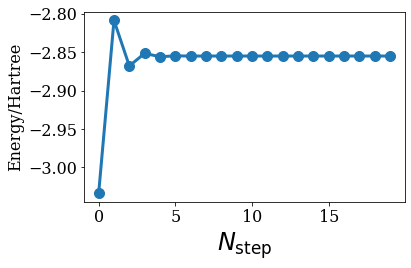

In [11]:
plt.plot(ener_traj,'o-',lw=3,markersize=10)
plt.xlabel(r"$N_{\rm{step}}$",fontsize=24)
plt.ylabel(r"Energy/Hartree")
figname='He_atom_HF.png'
plt.tight_layout()
plt.savefig(figname,dpi=300,format='png')
plt.show()

In [12]:
from pyscf import gto, scf

In [30]:
mol = gto.M(
    atom = [['He', (0, 0, 0)]],
    basis = "sto-3g", unit="bohr")

In [31]:
s=mol.intor("int1e_ovlp_sph")
t=mol.intor("int1e_kin_sph")
vne=mol.intor("int1e_nuc_sph")

In [32]:
Hcore = np.add(t,vne)
nao=mol.nao_nr() ## obtain the number of atomic orbitals.
print("Total number of basis fns:", nao)
print("Shape of overlap, kinetic, vne matrices", s.shape, t.shape, vne.shape)

Total number of basis fns: 1
Shape of overlap, kinetic, vne matrices (1, 1) (1, 1) (1, 1)


In [33]:
N_tot = nao

C0=np.zeros(N_tot)
for i in range(N_tot):
    C0[i] = 1.0E0
    
D = Build_DensMat(C0,s)

small_S, U = np.linalg.eigh(s)
## Step 2: Calculate s^{-1/2}.
half_S = np.zeros((N_tot,N_tot))
for i in range(N_tot):
    half_S[i,i] = 1.0E0/np.sqrt(np.abs(small_S[i]))
    #print(half_S[i,i])
## Step 3: Calculate V = Us^{-1/2}.
V = np.dot(U,half_S)
## Step 4: Calculate H' = V^d H V.
Vd = np.transpose(V)

In [34]:
Q=mol.intor("int2e_sph",aosym=1)
Q=np.reshape(Q,[nao,nao,nao,nao])

In [35]:
OldEner = -1.0E0
Ener    = 0.0E0

ener_traj = []
for i in range(20): 
    OldEner = Ener
    G = calc_G(N_tot,D,Q)
    F = calc_F(N_tot,G,Hcore)
    Ener, D_new = DiagFock(s,N_tot,F,Hcore,D,V,Vd,Q,i)

    ener_traj.append(Ener)
    D = copy.deepcopy(D_new)

After round    0 Energy:    -2.807784
After round    1 Energy:    -2.807784
After round    2 Energy:    -2.807784
After round    3 Energy:    -2.807784
After round    4 Energy:    -2.807784
After round    5 Energy:    -2.807784
After round    6 Energy:    -2.807784
After round    7 Energy:    -2.807784
After round    8 Energy:    -2.807784
After round    9 Energy:    -2.807784
After round   10 Energy:    -2.807784
After round   11 Energy:    -2.807784
After round   12 Energy:    -2.807784
After round   13 Energy:    -2.807784
After round   14 Energy:    -2.807784
After round   15 Energy:    -2.807784
After round   16 Energy:    -2.807784
After round   17 Energy:    -2.807784
After round   18 Energy:    -2.807784
After round   19 Energy:    -2.807784
